# Imports and Setups

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import csv

from mpl_toolkits.mplot3d import Axes3D

#import constants from grid.yp
from grid import *

#set parameters for prettier plots
%matplotlib inline
plt.rcParams['figure.dpi'] = 300

# Load Point Of Interest

In [2]:
POIS = {}
with open("pois.csv", newline="") as pois_csv:
    pois_r = csv.reader(pois_csv, delimiter=" ")
    pois_h = next(pois_r)
    for row in pois_r:
        poi_id, cell_id, poi_type, lat, lon = row
        poi_id, cell_id = int(poi_id), int(cell_id)
        lat, lon = float(lat), float(lon)
        if poi_type not in POIS.keys():
            POIS[poi_type] = [(poi_id, cell_id, lat, lon)]
        else:
            POIS[poi_type].append((poi_id, cell_id, lat, lon))

# Load Users Queries

In [3]:
QUERIES = {}
with open("queries.csv", newline="") as queries_csv:
    queries_r = csv.reader(queries_csv, delimiter=" ")
    queries_h = next(queries_r)
    for row in queries_r:
        ip_address, lat, lon, timestamp, poi_query_type = row
        lat, lon, timestamp = float(lat), float(lon), float(timestamp)
        if ip_address not in QUERIES.keys():
            QUERIES[ip_address] = [(lat, lon, timestamp, poi_query_type)]
        else:
            QUERIES[ip_address].append((lat, lon, timestamp, poi_query_type))

# Simulate Queries with our defence mecanism

In [4]:
QUERIES_MEC = {}

for k,v in QUERIES.items():
    QUERIES_MEC[k] = []
    for q in v:
        for t_list in POIS.values():
            for p_tuple in t_list:
                if q[0] == p_tuple[2] and q[1] == p_tuple[3]:
                    QUERIES_MEC[k].append((p_tuple[1], q[2], q[3]))
                    break      

In [5]:
with open('queries_mec.csv', 'w', newline='') as csvfile:
    fieldnames = ['ip_address', 'cell_id', 'timestamp', 'poi_query_type']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames, delimiter=" ")

    writer.writeheader()
    for k,v in QUERIES_MEC.items():
        for q in v:
            writer.writerow({'ip_address': k, 'cell_id': q[0], 'timestamp': q[1], 'poi_query_type': q[2]})

# Breach users privacy with our mechanism

In [6]:
#define types of POIs
HOME_TYPES = ["appartment_block", "villa"]
WORK_TYPES = ["office", "laboratory", "company"]

In [7]:
def match_location_poi(types):
    """return a dictionary whose keys are IP addresses and values dictionaries of a given type of POIs and their count"""
    
    LOCATIONS = {}
    for t in types:
        LOCATIONS[t] = POIS[t]

    LOCATIONS_USES_TEMP = {}
    for ip_address in list(QUERIES.keys()):
        LOCATIONS_USES_TEMP[ip_address] = []
        for q_lat, q_lon, _, _ in QUERIES[ip_address]:
            for l in list(LOCATIONS.values()):
                for poi_id, cell_id, h_lat, h_lon in l:
                    if h_lat == q_lat and h_lon == q_lon:
                        LOCATIONS_USES_TEMP[ip_address].append((poi_id, cell_id, h_lat, h_lon))

    LOCATIONS_USES = {}
    for k, v in LOCATIONS_USES_TEMP.items():
        LOCATIONS_USES[k] = {poi:v.count(poi) for poi in v}
    
    return LOCATIONS_USES

In [8]:
def check_one_location(matched_locations):
    """check if user have one and only one POI in a given dictionary"""
    
    for k in list(matched_locations.keys()):
        if len(list(matched_locations[k])) != 1:
            return False
        
    return True

## Do users use the app at home ?

In [9]:
home_poi = match_location_poi(HOME_TYPES)
check_one_location(home_poi)

True

## Do users use the app at work ?

In [10]:
work_poi = match_location_poi(WORK_TYPES)
check_one_location(work_poi)

True

## Observation
People of this dataset have only one home and one work location.

## Do users share home and work locations ?

In [11]:
ip_to_home_work = {}

for u in list(QUERIES.keys()):
    h = list(home_poi[u].keys())[0]
    w = list(work_poi[u].keys())[0]
    ip_to_home_work[u] = (h,w)

In [12]:
ip_to_home_work_mec = {}

for k,v in ip_to_home_work.items():
    ip_to_home_work_mec[k] = (-1,-1)
    for q in v:
        h,w = v
        for t_list in POIS.values():
            for p_tuple in t_list:
                if h[2] == p_tuple[2] and h[3] == p_tuple[3]:
                    ip_to_home_work_mec[k] = ((p_tuple[1],ip_to_home_work_mec[k][1]))
                elif w[2] == p_tuple[2] and w[3] == p_tuple[3]:
                    ip_to_home_work_mec[k] = ((ip_to_home_work_mec[k][0],p_tuple[1]))
                if ip_to_home_work_mec[k][0] >= 0 and ip_to_home_work_mec[k][1] >= 0:
                    break

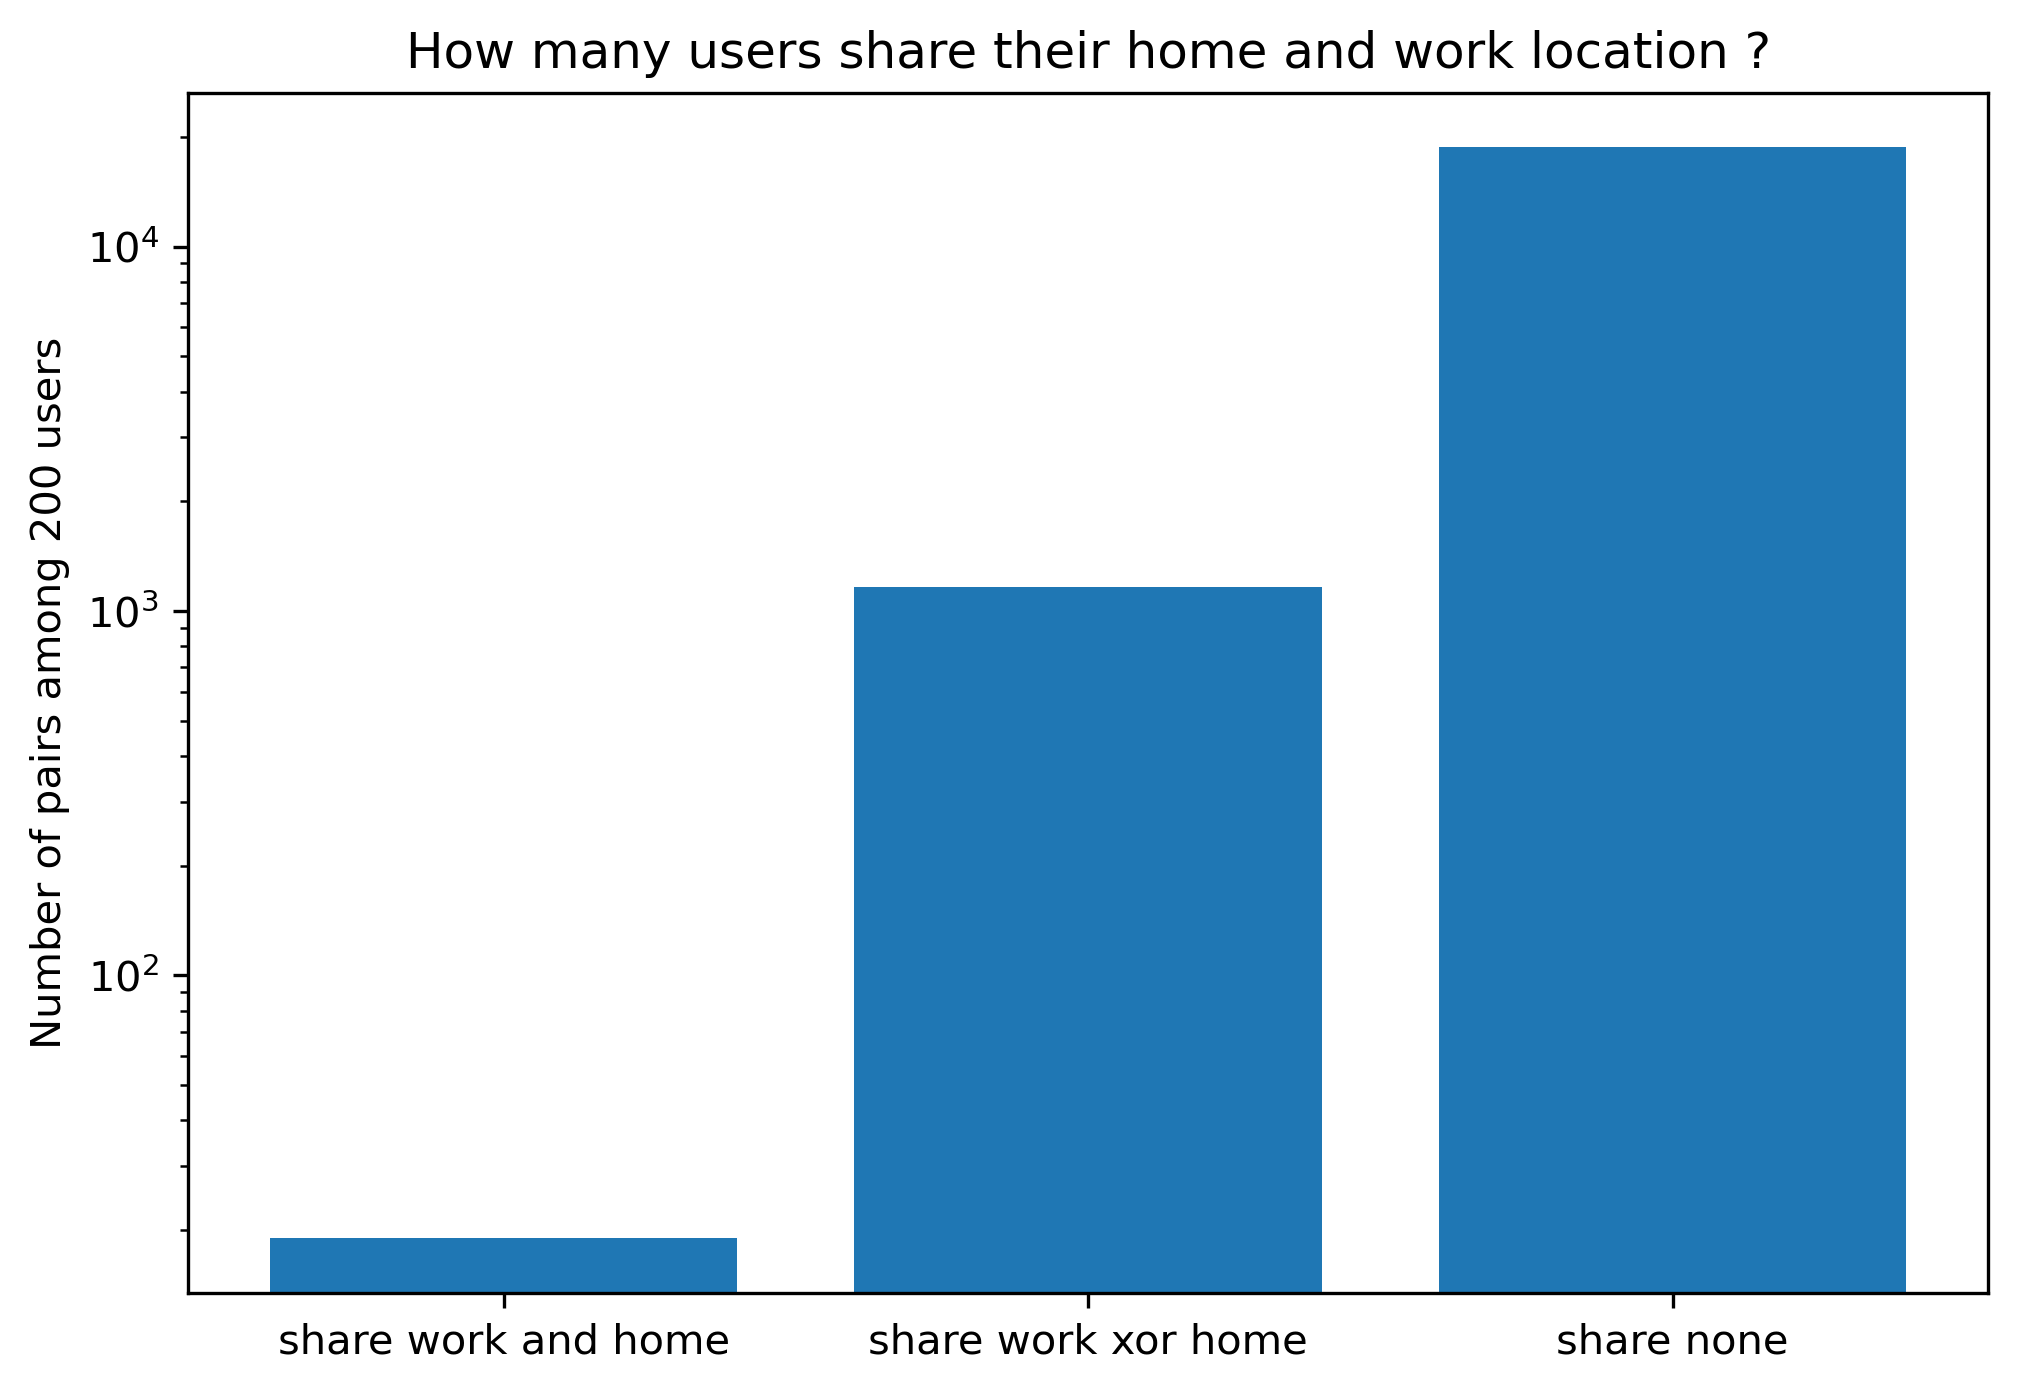

In [13]:
def plot_pairs():
    """visualize how users share home and work locations"""
    
    share_none = 0
    share_one  = 0
    share_both = 0

    users = list(QUERIES.keys())
    for i in range(len(users)):
        for j in range(i+1, len(users)):
            u, v = users[i], users[j]
            if ip_to_home_work_mec[u] == ip_to_home_work_mec[v]:
                share_both += 1
            elif ip_to_home_work_mec[u][0] == ip_to_home_work_mec[v][0] or ip_to_home_work_mec[u][1] == ip_to_home_work_mec[v][1]:
                share_one += 1
            else:
                share_none += 1
                
    fig = plt.figure()
    
    ax = fig.add_axes([0,0,1,1])
    ax.set_yscale('log')
    ax.bar(['share work and home', 'share work xor home', 'share none'], [share_both, share_one, share_none])
    
    plt.title("How many users share their home and work location ?")
    plt.ylabel("Number of pairs among 200 users")
    
    plt.savefig("share_mec.png", dpi=300, bbox_inches='tight')
    
    plt.show()
    
plot_pairs()